**Import Library**

In [289]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import sympy as sp
from PIL import Image
import os

**Function**

In [290]:
#Process the Image into a flat 1D array
def ProcessImage(img):
    Grayscale = img.convert('L')
    Facematrix = im.pil_to_array(Grayscale)/255
    FlatFaceArray = np.concat(Facematrix,axis=None)

    return FlatFaceArray

#More efficent way to calculate the svd of the datamatrix
def svd(X):
    XtX = X.T @ X
    V, S, Vt = np.linalg.svd(XtX)
    S_matrix = np.sqrt(np.diag(S))
    S_inv = np.linalg.inv(S_matrix)
    U = X @ V @ S_inv
    return U, np.sqrt(S), Vt

# Yale database

In [235]:
#Yale datamtrix
# filename structure
path = 'yale/' # path to the database
ids = range(1, 16) # 15 persons
states = ['centerlight', 'glasses', 'happy', 'leftlight',
          'noglasses', 'normal', 'rightlight','sad',
          'sleepy', 'surprised', 'wink' ]
prefix = 'subject'
surfix = '.pgm'
num_files = len(states)
num_class = 15
num_total = num_class * num_files
# data dimension
Height, Width = im.pil_to_array(Image.open('yale\\subject01.happy.pgm')).shape
D = Height * Width
# collect all data
FullMatrix = np.zeros((D, num_total))
cnt = 0
for person_id in range(1, 16):
    for state in states:
        fn = path + prefix + str(person_id).zfill(2) + '.' + state + surfix
        FullMatrix[:, cnt] = ProcessImage(Image.open(fn))
        cnt += 1

def ClassMatrix(k:int):
    return FullMatrix[:,num_files*(k-1):num_files*k]
FullMatrix.shape

(77760, 165)

# ORL database

In [291]:
#Size of the image
FaceArray = im.pil_to_array(Image.open("archive\\s1\\1.pgm"))
Height, Width = FaceArray.shape
#Number of classes
num_class = sum(1 for entry in os.scandir("archive") if not entry.is_file())
#Number of files in a class
num_files = sum(1 for entry in os.scandir("archive\\s1") if entry.is_file())-5
#Total number of files
num_total = num_files*num_class

D = Height * Width
#Make the Data Matrix
FullMatrix = np.zeros((D,num_total))
cnt = 0
for i in range(num_class):
    for j in range(num_files):
        imgdir = "archive\\s" + str(i+1) +"\\" +str(j+1) +".pgm"
        FullMatrix[:, cnt] = ProcessImage(Image.open(imgdir))
        cnt +=1

def ClassMatrix(k:int):
    return FullMatrix[:,num_files*(k-1):num_files*k]
FullMatrix.shape

(10304, 200)

In [292]:
#The average face
MeanFace=np.mean(FullMatrix, axis=1)
ColumnMeanFace= MeanFace[:, np.newaxis]
print(MeanFace)

[0.33329412 0.33321569 0.33486275 ... 0.28241176 0.28635294 0.28154902]


**Calculate the eigenvalues and eigenfaces**

In [293]:
#Minus the mean
CenteredFullMatrix=FullMatrix  - ColumnMeanFace
#Find the Eigenface of the Data
U, S, Vt = svd(CenteredFullMatrix)
#Find the needed amount of eigenvalues
eigsum=np.sum(S)
csum=0
for i in range(S.shape[0]):
    csum +=S[i]
    if csum > 0.9*eigsum:
        e90=i
        break

#S_matrix = np.zeros(np.diag(S).shape)
#S_matrix[:e90, :e90] = np.sqrt(np.diag(S_reduced))
#Reducing the eigenvalues and vector to the needed amount
U_reduced = U[:,:e90]
S_reduced= np.sqrt(np.diag(S[0:e90]))
e90
U_reduced.shape

(10304, 150)

In [294]:
#Projecting a vector in to the facespace
def Facespace(vector):
    return  vector @ U_reduced

#the average of a class k in facespace
def avgClassOmega(k: int):
    S = 0
    for i in range(num_files):
        S+= Facespace(ClassMatrix(k)[:,i]-MeanFace)
    return S/len(range(num_files))

#Find the threshold for the picture to be indentified as a face in class k
def Classepsilon(k: int):
    Cepsilon = 0
    for i in range(num_files):
        e=np.linalg.norm(Facespace(ClassMatrix(k)[:,i] - MeanFace)-avgClassOmega(k))
        if e > Cepsilon:
            Cepsilon = e
    return Cepsilon*2

#np.linalg.norm(avgClassOmega(34)), np.linalg.norm(Facespace(ClassMatrix(1)[:,1])-avgClassOmega(34))
Facespace(CenteredFullMatrix[:,1]).shape

(150,)

In [295]:

#The average of all the data in facespace
#S = 0
#for i in range(num_total):
#    S = S+ Facespace(CenteredFullMatrix[:,i])
#avgOmega = S#/len(range(num_files))
#Find the threshold for the picture to be identified as a face, let that be epsilon
epsilon=0
#Array of a facevector after being transform in facespace
def Ffacearray(facearray):
    return Facespace(facearray) @ U_reduced.T
for i in range(num_total):
    facearray = CenteredFullMatrix[:,i]
    e = np.linalg.norm(facearray-Ffacearray(facearray))
    if e > epsilon:
        epsilon = e
#Let the threshold be 2epsilon
epsilon = 5*epsilon
epsilon
#Facespace(ClassMatrix(2)[:,1]).shape

np.float64(17.200176772834443)

**Face recognization**

In [296]:

#Input = ProcessImage(Image.open("32.JPG"))-MeanFace
#Input.shape
#Let the image that need to be specify is input
def Facedetect(imgdir: str ):
    image=Image.open(imgdir)
    facearray = ProcessImage(image)-MeanFace
    dist = np.linalg.norm(facearray - Ffacearray(facearray))
    if epsilon > dist:
        print("this image contains a face")
    else: 
        print("this image does not contain a face")
    print(dist)

def EigenClassify(imgdir: str):
    image = Image.open(imgdir)
    facearray = ProcessImage(image) - MeanFace
    dist = 1000
    for i in range(num_class):
        dist2 = np.linalg.norm(Facespace(facearray) - avgClassOmega(i+1))
        if dist2 < dist:
            dist = dist2
            k = i
    if dist <= Classepsilon(k+1):
        return k+1
    else:
        return 0


In [297]:
Facedetect("input2.png")

this image does not contain a face
19.58609107006067


# Fisher face

In [298]:
#SVD ma trận data ban đầu
U, S, V = svd(CenteredFullMatrix)
U.shape

(10304, 200)

**Ta lấy PCA ma trận về N-c chiều**

In [299]:
#Lấy số chiều cần cho LDA
W_pca = U[:,:num_total - num_class]
W_pca.shape

(10304, 160)

Tìm Sb và Sw

In [300]:
#Mean của một class
def MeanClassFace(k: int):
    MeanFace=np.mean(ClassMatrix(k), axis=1)
    return MeanFace[:, np.newaxis]
#Tìm Sb
for i in range(num_class):
    if i == 0:
        Xb = MeanClassFace(i+1) - ColumnMeanFace
    else:
        Xb = np.column_stack((Xb,MeanClassFace(i+1)-ColumnMeanFace))
Xb2 = W_pca.T @ Xb
Sb = num_files * Xb2 @ Xb2.T
np.linalg.matrix_rank(Sb)

np.int64(39)

In [301]:
for i in range(num_class):
    if i == 0:
        Xw = ClassMatrix(i+1) - MeanClassFace(i+1)
        Xw2 = W_pca.T @ Xw
        Sw = Xw2 @ Xw2.T
    else:
        Xw = ClassMatrix(i+1) - MeanClassFace(i+1)
        Xw2 = W_pca.T @ Xw
        Sw += Xw2 @ Xw2.T
W_pca.shape

(10304, 160)

In [302]:
#LDA
U, S, Vt = np.linalg.svd(np.linalg.inv(Sw) @ Sb)
#Giảm các ma trận về số chiều cần dùng (rank của Sb)
dim = np.linalg.matrix_rank(Sb)
W_lda= U[:, :dim] 
S_lda= np.diag(S[0:dim])
W_lda.shape

(160, 39)

In [303]:
W_opt=W_pca @ W_lda
W_opt.shape

(10304, 39)

In [304]:
def Fisherfacespace(vec):
    return W_opt.T @ vec
#the average of a class k in facespace
def avgFisherClass(k: int):
    S = 0
    for i in range(num_files):
        S+= Fisherfacespace(ClassMatrix(k)[:,i]-MeanFace)
    return S/len(range(num_files))

#Find the threshold for the picture to be indentified as a face in class k
def FisherClassepsilon(k: int):
    Cepsilon = 0
    for i in range(num_files):
        e=np.linalg.norm(Fisherfacespace(ClassMatrix(k)[:,i]-MeanFace)-avgFisherClass(k))
        if e > Cepsilon:
            Cepsilon = e
    return Cepsilon*2

def FisherClassify(imgdir: str):
    image = Image.open(imgdir)
    facearray = ProcessImage(image) - MeanFace
    dist = 1000
    for i in range(num_class):
        dist2 = np.linalg.norm(Fisherfacespace(facearray) - avgFisherClass(i+1))
        if dist2 < dist:
            dist = dist2
            k = i
    if dist <= FisherClassepsilon(k+1)*10:
        return k+1
    else:
        return 0


In [305]:
def Classify(imgdir: str, mode: str):
    if mode == "e":
        c = EigenClassify(imgdir)
    elif mode == "f":
        c = FisherClassify(imgdir)
    if c == 0:
        print("This image is not identified")
    else:
        print(f"This image is in class {c}")

In [307]:
Classify("archive\\s1\\9.pgm", "e")

This image is in class 1


# Make the comparison data 

In [308]:
#Let the input be the 9th and 10th image of each class
#Let S be the counter for success classify attempt
S = 0
#Let T be the total amouth of attempt
T = num_class*2
for i in range(num_class):
    for j in [9,10]:
        if EigenClassify(f"archive\\s{i+1}\\{j}.pgm") == i+1:
            S+=1
S/T

0.8625

In [285]:
#Let S be the counter for success classify attempt
S = 0
#Let T be the total amouth of attempt
T = num_class*2
for i in range(num_class):
    for j in [9,10]:
        if FisherClassify(f"archive\\s{i+1}\\{j}.pgm") == i+1:
            S+=1
S/T

0.9375

In [ ]:
S = 0
T = num_class*2

path = 'yale/' # path to the database
ids = range(1, 16) # 15 persons
#states = ['centerlight', 'glasses', 'happy', 'leftlight','noglasses', 'normal', 'rightlight','sad', 'sleepy', 'surprised', 'wink' ]
states = ['surprised', 'wink' ]

prefix = 'subject'
surfix = '.pgm'
for person_id in range(1, 16):
    for state in states:
        fn = path + prefix + str(person_id).zfill(2) + '.' + state + surfix
        if FisherClassify(fn) == person_id:
            S +=1

S/T

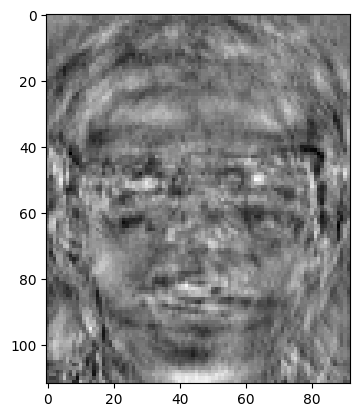

In [ ]:
plt.imshow(im.reshape((Height, Width)), cmap=plt.cm.gray)
plt.imshow(W_opt[:,1].reshape((Height,Width)), cmap=plt.cm.gray)

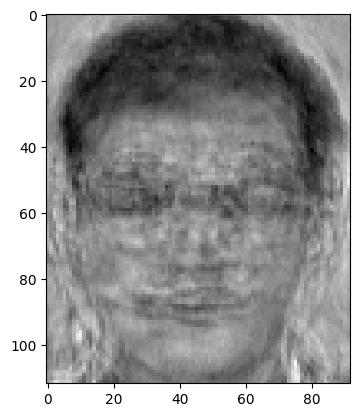

In [723]:
plt.figure()
img = ProcessImage(Image.open("18.JPG"))
#img = CenteredFullMatrix[:,3]
plt.imshow(img.reshape((Height, Width)), cmap=plt.cm.gray)
plt.imshow(Ffacearray(img).reshape((Height, Width)),cmap=plt.cm.gray)
#ProcessImage(Image.open("input.JPG"))


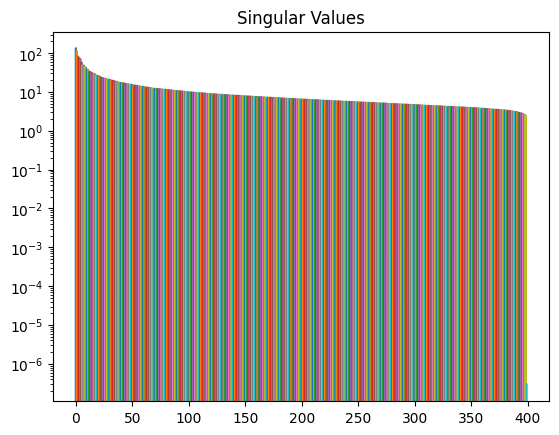

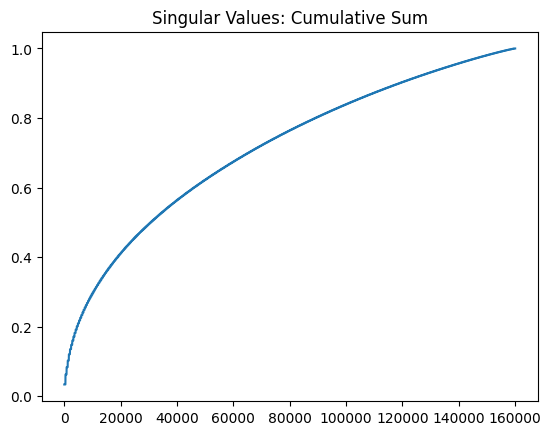

In [ ]:
def plot_cumulative_sum(Sr):
    plt.clf
    plt.figure(1)
    plt.semilogy(np.diag(Sr))
    plt.title('Singular Values')
    plt.show()

    plt.figure(1)
    plt.plot(np.cumsum(np.diag(Sr))/np.sum(np.diag(Sr)))
    plt.title('Singular Values: Cumulative Sum')
    plt.show()
plot_cumulative_sum(S)